<a href="https://colab.research.google.com/github/JayVeer18/MiniProject/blob/main/Diagnoising_Covid_CT_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---
#### Uploading DataSet from local Machine to Google Colab


---
from google.colab import files

uploaded=files.upload()

for fn in uploaded.keys():

  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))


---
Mounting your Google Drive to load DataSet

---
from google.colab import drive

drive.mount('/content/drive')


In [ ]:
#@title Uploading files from Google drive if we know the shared file link
!gdown --id 1x7igRmLhhyttjgJWxzmHSK9uDHuVr518

Downloading...
From: https://drive.google.com/uc?id=1x7igRmLhhyttjgJWxzmHSK9uDHuVr518
To: /content/DATASET.zip
90.1MB [00:01, 73.4MB/s]


In [ ]:
#@title UNZIP in Google Colab { vertical-output: true, display-mode: "form" }
#@markdown !unzip cmd will work for the files with extension .zip 
#@markdown However, for .gz or .tgz files, try the !gunzip command instead.
!unzip DATASET.zip

In [ ]:
#@title Importing necessary Libraries { vertical-output: true, display-mode: "form" }
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dropout,Activation
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,f1_score,precision_score,classification_report,jaccard_similarity_score
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import IPython.display as display
from PIL import Image 

import numpy as np
import cv2
import os
from tqdm import tqdm
import random
from shutil import copyfile

import zipfile
import time

In [ ]:
#@title Global Parameters { display-mode: "form" }

INIT_LR = 3e-4  # learning rate
EPOCHS = 500  # training epochs
BS = 16  # batch size
DATASET_PATH = r'/content/DATASET'
CATEGORIES =['CT_NonCOVID','CT_COVID']
IMG_SIZE = 224
TEST_SET_SIZE = 0.2
classNames = ['Non-Covid','Covid']
lb = LabelBinarizer()



---

## Preprocessing

---



In [ ]:
#@title Function to Display Sample Image { vertical-output: true, display-mode: "form" }
variable_name = ""
def displayImages(images,IMG_SIZE):
  fig,ax = plt.subplots(1, len(images),figsize=(15,15),sharey=True)
  fig.subplots_adjust(top=0.5)
  i=0
  for img in images:
        img_array = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        ax[i].imshow(new_array, cmap='gray')
        i+=1
  ax[2].set_title('Sample Images',fontsize=32)      
  fig.tight_layout()
  plt.show()

In [ ]:
#@title Reading Images from the Dataset { vertical-output: true, display-mode: "form" }
def readImages(DATASET_PATH,CATEGORIES,IMG_SIZE):
    training_data = []
    imgpath = []
    j=0
    for category in CATEGORIES:
        path = os.path.join(DATASET_PATH,category) 
        class_label = category.split('_')[1] # get the label
        i = 0+j
        j+=1
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([new_array, class_label])  # add this to our training_data
            if i < 3:
              imgpath.append(os.path.join(path,img))
            i+=1 
    displayImages(imgpath,IMG_SIZE)
    return training_data

100%|██████████| 349/349 [00:01<00:00, 240.01it/s]


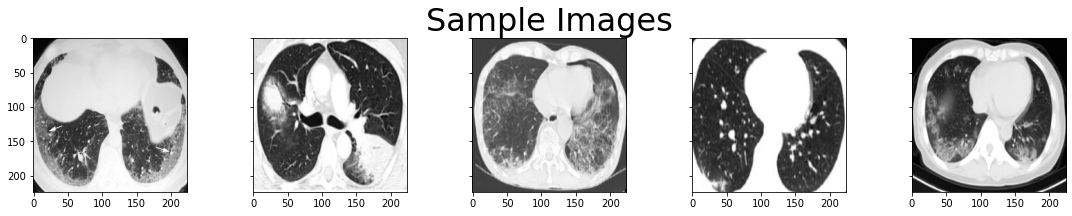

The size of dataset :  746


In [ ]:
#@title Extracting Input from the dataset { vertical-output: true, display-mode: "form" }
y_dnn=""
X_dnn=""
def preprocess():
  global y_dnn
  global x_dnn
  dataset = readImages(DATASET_PATH,CATEGORIES,IMG_SIZE)
  print("The size of dataset : ",len(dataset))
  #randomise the data for best splitting

  random.shuffle(dataset)
  X = []
  y = []

  for features,label in dataset:
      X.append(features)
      y.append(label)
  X = np.array(X)
  x_dnn = X.reshape(-1,IMG_SIZE*IMG_SIZE*3)
  X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
  X = X/255.0
  y = np.array(y)
  y = lb.fit_transform(y)
  y_dnn=y
  y = to_categorical(y)
  return train_test_split(X, y,test_size=TEST_SET_SIZE, stratify=y, random_state=42)
(trainX, testX, trainY, testY) = preprocess()

In [ ]:
#@title Saving dataset as pickel file
import pickle
names = ['trainX', 'testX', 'trainY', 'testY']
for i in names:
  pickle_out = open(str(i+".pickle"),"wb")
  pickle.dump(i, pickle_out)
  pickle_out.close()
  print(str(i+".pickle"))


trainX.pickle
testX.pickle
trainY.pickle
testY.pickle


In [ ]:
#@title Load data fom pickle file
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mv "/content/pca.pkl" "/content/drive/MyDrive/MiniProject"



---

## Different plots

---



In [ ]:
#@title Function to plot Confusion Matrix { vertical-output: true, display-mode: "form" }
def plotconfusematrix(cm_train,cm_test,classNames):
    tick_marks = np.arange(len(classNames))
    s = [['TN','FP'], ['FN', 'TP']]
    
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    total = np.sum(cm_train)
    ax[0].set_title('Confusion Matrix - Train Data')
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')
    ax[0].set_xticks(tick_marks)
    ax[0].set_yticks(tick_marks)
    ax[0].set_xticklabels(classNames)
    ax[0].set_yticklabels(classNames)
    plt.setp(ax[0].get_yticklabels(), rotation=90)
    ax[0].imshow(cm_train, interpolation='nearest', cmap='Blues')
    for i in range(2):
        for j in range(2):
            ax[0].text(j,i, str(s[i][j])+" = "+str(cm_train[i][j])+"\n"+"{0:.2%}".format(cm_train[i][j]/total))
    
    total = np.sum(cm_test)
    ax[1].set_title('Confusion Matrix - Test Data')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylabel('True label')
    ax[1].set_xticks(tick_marks)
    ax[1].set_yticks(tick_marks)
    ax[1].set_xticklabels(classNames)
    ax[1].set_yticklabels(classNames)
    plt.setp(ax[1].get_yticklabels(), rotation=90)
    ax[1].imshow(cm_test, interpolation='nearest', cmap='Blues')
    for i in range(2):
        for j in range(2):
            ax[1].text(j,i, str(s[i][j])+" = "+str(cm_test[i][j])+"\n"+"{0:.2%}".format(cm_test[i][j]/total))
    
    fig.tight_layout()
    plt.show()

def confusematrix(model,trainX,trainY,testX,testY,classNames):
    yhat = model.predict(trainX, batch_size=BS)
    yhat = np.argmax(yhat, axis=1) # argmax for the predicted probability
    cm_train = confusion_matrix(trainY.argmax(axis=1), yhat)
    
    pred = model.predict(testX, batch_size=BS)
    pred = np.argmax(pred, axis=1) # argmax for the predicted probability
    cm_test = confusion_matrix(testY.argmax(axis=1), pred)
    print(' \tTraining Accuracy : ',accuracy_score(trainY.argmax(axis=1),yhat),'\t\t\tTesting Accuracy : ',accuracy_score(testY.argmax(axis=1),pred))
    plotconfusematrix(cm_train,cm_test,classNames)   
    return testY.argmax(axis=1),pred,cm_test

In [ ]:
#@title Function definition for Accuracy and Loss Plots { vertical-output: true, display-mode: "form" }
def plothistory(history):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(13,5))
    ax1.plot(history.history['accuracy'],'r-')
    ax1.plot(history.history['val_accuracy'],'b-')
    ax1.set_title('model accuracy')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['Train Accuracy', 'Test Accuracy'], loc='upper left')
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(['Train Loss', 'Test Loss'], loc='upper left')
    plt.tight_layout()

In [ ]:
#@title Function for Performance Metrics { vertical-output: true, display-mode: "form" }
from prettytable import PrettyTable

def performance_metrics(y_test,yhat,cm,title):
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    t = PrettyTable(['Preformance_Metrics',title])
    t.add_row(['Precision ',precision_score(y_test, yhat, average="macro")])
    t.add_row(['Miss-Rate ', FN / (FN + TP)])
    t.add_row(['Fall-out ', FP / (FN + TP)])
    t.add_row(['Sensitivity or recall ',recall_score(y_test, yhat , average="macro")])
    t.add_row(['Accuracy ',accuracy_score(y_test,yhat)])
    t.add_row(['Specificity ', TN/(TN + FP)])
    t.add_row(['F1 Score ',f1_score(y_test, yhat , average="macro")])
    t.add_row(['Similarity of Jaccard',TP/(TP + FP + FN)])
    t.add_row(['S-dice ',(2*TP)/(2*TP + FP + FN)])  
    print(t)



---

## Method:1 - DNN with Feature Extraction

---



#### (A) Feature Extraction

In [ ]:
#@title Extracting Features
from sklearn import decomposition, datasets
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
print("Initial features: "+str(x_dnn.shape[1]))
x_std = sc.fit_transform(x_dnn)
pca = decomposition.PCA(n_components=512)
x_new = pca.fit_transform(x_std)
print("Extracted features: "+str(x_new.shape[1]))

Initial features: 150528
Extracted features: 512


In [ ]:
#@title Splitting Data { vertical-output: true }
variable_name = ""
X_train, X_test_dnn, y_train, y_test_dnn = train_test_split(x_new, y_dnn, test_size=0.30, random_state=42)
input_shape = X_train.shape[1:]
print("samples for training: "+str(X_train.shape[0]))
print("samples for testing: "+str(X_test_dnn.shape[0]))

samples for training: 522
samples for testing: 224


### (B)DNN Model

In [ ]:
#@title Creating DNN Model { vertical-output: true }
import tensorflow
from tensorflow.keras.layers import Dropout
def create_dnn_model():
  dnn_model=Sequential()
  dnn_model.add(Dense(256, activation='relu', input_shape=input_shape))
  dnn_model.add(Dense(256, activation='relu'))
  dnn_model.add(Dense(128, activation='relu'))
  dnn_model.add(Dense(128, activation='relu'))
  dnn_model.add(Dense(64, activation='relu'))
  dnn_model.add(Dense(64, activation='relu'))
  dnn_model.add(Dense(32, activation='relu'))
  dnn_model.add(Dropout(0.5))
  dnn_model.add(Dense(1, activation='sigmoid'))
  dnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy','mse'])
  dnn_model.summary()
  return dnn_model
dnn_model=create_dnn_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2

### (C) Combining DNN with feature Extraction

In [ ]:
#@title Training the DNN Model { vertical-output: true }
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.85):
      print("\nReached 85% accuracy so cancelling training!")
      self.model.stop_training = True
checkpoint = ModelCheckpoint(r'Covid_result_DNN.h5',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
dnn_history = dnn_model.fit(
                    x = X_train, 
                    y = y_train,
                    batch_size=BS,
                    epochs = EPOCHS,
                    callbacks = [myCallback(),checkpoint],
                    validation_data=(X_test_dnn, y_test_dnn),
                    )

Epoch 1/500
33/33 [==============================] - ETA: 0s - loss: 0.9714 - accuracy: 0.5728 - mse: 0.2942
Epoch 00001: val_accuracy improved from -inf to 0.60714, saving model to Covid_result_DNN.h5
33/33 [==============================] - 0s 11ms/step - loss: 0.9714 - accuracy: 0.5728 - mse: 0.2942 - val_loss: 0.6665 - val_accuracy: 0.6071 - val_mse: 0.2361
Epoch 2/500
33/33 [==============================] - ETA: 0s - loss: 0.6175 - accuracy: 0.6628 - mse: 0.2129
Epoch 00002: val_accuracy improved from 0.60714 to 0.69196, saving model to Covid_result_DNN.h5
33/33 [==============================] - 0s 6ms/step - loss: 0.6175 - accuracy: 0.6628 - mse: 0.2129 - val_loss: 0.5814 - val_accuracy: 0.6920 - val_mse: 0.2001
Epoch 3/500
33/33 [==============================] - ETA: 0s - loss: 0.3966 - accuracy: 0.8161 - mse: 0.1280
Epoch 00003: val_accuracy did not improve from 0.69196
33/33 [==============================] - 0s 4ms/step - loss: 0.3966 - accuracy: 0.8161 - mse: 0.1280 - val

In [ ]:
#@title Accuracy Calculation { vertical-output: true }
dnn_model = tf.keras.models.load_model('/content/Covid_result_DNN.h5')
y_predicted=dnn_model.predict(X_test_dnn)
pred=[]
for val in y_predicted.T[0]:
    pred.append(round(val))
score = dnn_model.evaluate(X_test_dnn, y_test_dnn, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
score = dnn_model.evaluate(X_train, y_train, verbose=0)
print(f'Train loss: {score[0]} / Train accuracy: {score[1]}')
print('Accuracy : ',accuracy_score(y_test_dnn,pred))

Test loss: 15.53707218170166 / Test accuracy: 0.7366071343421936
Train loss: 2.2083319534452715e-14 / Train accuracy: 1.0
Accuracy :  0.7366071428571429


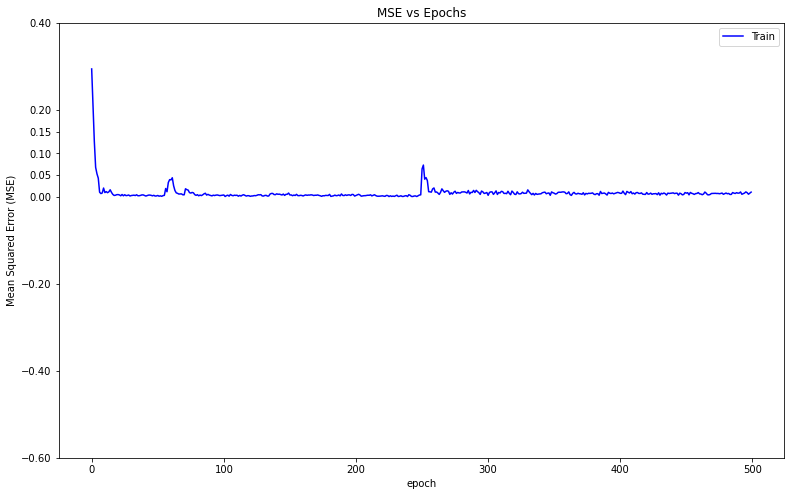

In [ ]:
#@title Graphs  { vertical-output: true }
def plot_his(history):
    fig, (ax1) = plt.subplots(1, 1,figsize=(13,8))
    ax1.plot(history.history['mse'],'b-')
    ax1.set_title('MSE vs Epochs')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('Mean Squared Error (MSE)')
    ax1.set_yticks([-0.6,-0.4,-0.2,0,0.05,0.1,0.15,0.2,0.4])
    ax1.legend(['Train'], loc='upper right')
plot_his(dnn_history)

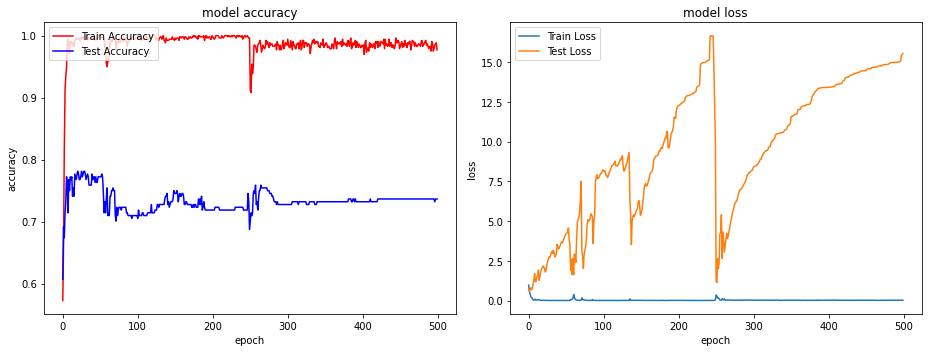

In [ ]:
plothistory(dnn_history)

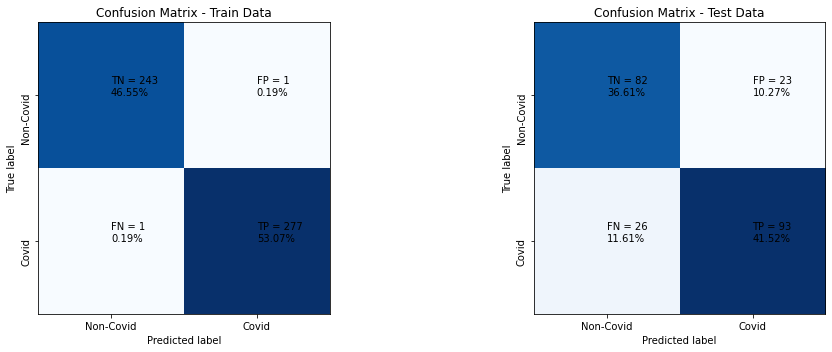

In [ ]:
#@title Plot Confusion Matrix { vertical-output: true }
from sklearn.metrics import confusion_matrix
y_predicted=dnn_model.predict(X_train)
pred=[]
for val in y_predicted.T[0]:
    pred.append(round(val))
pred=np.array(pred)
cm_train=confusion_matrix(y_train,pred)

y_predicted=dnn_model.predict(X_test_dnn)
pred=[]
for val in y_predicted.T[0]:
    pred.append(round(val))
pred=np.array(pred)
cm_dnn=confusion_matrix(y_test_dnn,pred)

plotconfusematrix(cm_train,cm_dnn,classNames)

In [ ]:
 performance_metrics(y_test_dnn,pred,cm_dnn,'DNN')

+------------------------+---------------------+
|  Preformance_Metrics   |         DNN         |
+------------------------+---------------------+
|       Precision        |  0.7804916985951469 |
|       Miss-Rate        |  0.2184873949579832 |
|       Fall-out         | 0.19327731092436976 |
| Sensitivity or recall  |  0.7812324929971989 |
|       Accuracy         |       0.78125       |
|      Specificity       |  0.780952380952381  |
|       F1 Score         |   0.78072120667266  |
| Similarity of Jaccard  |  0.6549295774647887 |
|        S-dice          |  0.7914893617021277 |
+------------------------+---------------------+




---
## Method:2 - CNN Method


---



### PROPOSED CNN MODEL
![Architecture](https://ars.els-cdn.com/content/image/1-s2.0-S096007792030566X-gr6_lrg.jpg)


---





In [ ]:
#@title Proposed CNN MODEL { vertical-output: true, display-mode: "form" }
def createmodel():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 8,kernel_size = (3,3),strides = (1,1),input_shape = (224, 224, 3),padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid'),
 
    tf.keras.layers.Conv2D(filters = 16,kernel_size = (3,3), strides = (1,1),padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2,2), padding='valid'),
 
    tf.keras.layers.Conv2D(filters = 3,kernel_size = (3,3), strides = (1,1),padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(rate=0.4),
 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2),
    tf.keras.layers.Activation('softmax')
  ])
  opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
  model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
  return model
pmodel = createmodel()
pmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 8)       32        
_________________________________________________________________
activation (Activation)      (None, 224, 224, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 16)     



---

#### Training the Proposed CNN Model

---



In [ ]:
#@title Training The Proposed Model { vertical-output: true, display-mode: "form" }
# Define a Callback class that stops training once accuracy reaches 91.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.90):
      print("\nReached 91% accuracy so cancelling training!")
      self.model.stop_training = True
checkpoint = ModelCheckpoint(r'Covid_result_Normal.h5',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.2,patience=5,verbose=2,min_delta=0.0001)
history_normal = pmodel.fit(
                    x = trainX, 
                    y = trainY,
                    batch_size=BS,
                    epochs = 100,
                    callbacks = [myCallback(),checkpoint,reduce_lr],
                    steps_per_epoch=len(trainX) // BS,
                    validation_data=(testX, testY),
                    validation_steps=len(testX) // BS,
                    )

print("[INFO] saving COVID-19 detector model...")

Epoch 1/100
35/37 [===========================>..] - ETA: 0s - loss: 0.7296 - accuracy: 0.6339
Epoch 00001: val_accuracy improved from -inf to 0.52083, saving model to Covid_result_Normal.h5
37/37 [==============================] - 1s 24ms/step - loss: 0.7359 - accuracy: 0.6368 - val_loss: 0.6843 - val_accuracy: 0.5208
Epoch 2/100
37/37 [==============================] - ETA: 0s - loss: 0.4893 - accuracy: 0.7707
Epoch 00002: val_accuracy did not improve from 0.52083
37/37 [==============================] - 1s 17ms/step - loss: 0.4893 - accuracy: 0.7707 - val_loss: 0.7242 - val_accuracy: 0.5208
Epoch 3/100
37/37 [==============================] - ETA: 0s - loss: 0.2926 - accuracy: 0.8759
Epoch 00003: val_accuracy did not improve from 0.52083
37/37 [==============================] - 1s 17ms/step - loss: 0.2926 - accuracy: 0.8759 - val_loss: 1.0189 - val_accuracy: 0.5208
Epoch 4/100
37/37 [==============================] - ETA: 0s - loss: 0.1835 - accuracy: 0.9310
Epoch 00004: val_accurac

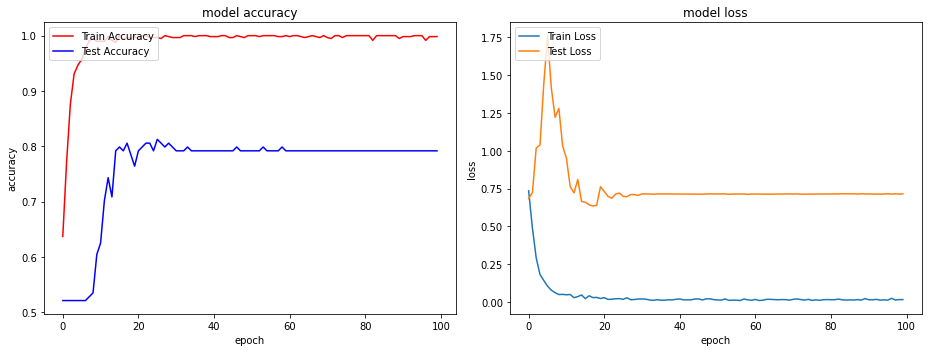

In [ ]:
#@title Accuracy and Loss Plots for Proposed CNN { vertical-output: true, display-mode: "form" }
plothistory(history_normal)

 	Training Accuracy :  0.9546979865771812 			Testing Accuracy :  0.9733333333333334


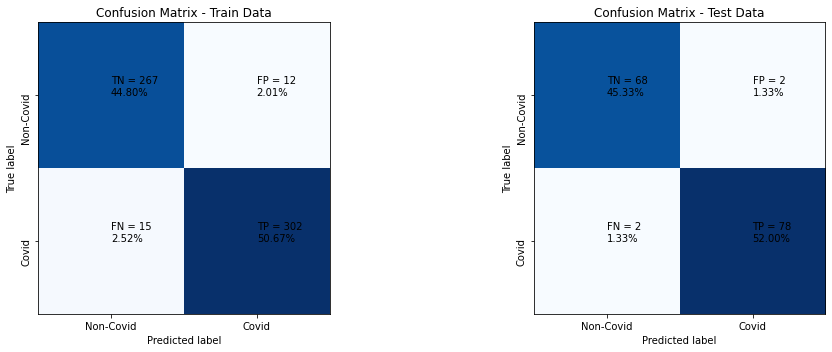

              precision    recall  f1-score   support

       COVID       0.97      0.97      0.97        70
    NonCOVID       0.97      0.97      0.97        80

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



In [ ]:
#@title plotting confusion matrix and classification Report for Proposed CNN { vertical-output: true, display-mode: "form" }
new_model = tf.keras.models.load_model('/content/drive/MyDrive/MiniProject/Covid_result_Normal.h5')
y_test_cnn,yhat_cnn,cm_cnn = confusematrix(new_model,trainX,trainY,testX,testY,classNames)
print(classification_report(y_test_cnn,yhat_cnn,target_names=lb.classes_))

In [ ]:
#@title Performance Metrics for Proposed CNN Model{ vertical-output: true, display-mode: "form" }
performance_metrics(y_test_cnn,yhat_cnn,cm_cnn,'Proposed CNN Model')

+------------------------+--------------------+
|  Preformance_Metrics   | Proposed CNN Model |
+------------------------+--------------------+
|       Precision        | 0.8138528138528138 |
|       Miss-Rate        |        0.15        |
|       Fall-out         |        0.2         |
| Sensitivity or recall  | 0.8107142857142857 |
|       Accuracy         | 0.8133333333333334 |
|      Specificity       | 0.7714285714285715 |
|       F1 Score         | 0.8116929698708752 |
| Similarity of Jaccard  | 0.7083333333333334 |
|        S-dice          | 0.8292682926829268 |
+------------------------+--------------------+




---

#### Training the Proposed-model using Image Augumentation 

---



In [ ]:
COVID_SOURCE_DIR = '/content/DATASET/CT_COVID'
TRAINING_DIR = '/content/covid-vs-noncovid/training'
TESTING_DIR =  '/content/covid-vs-noncovid/testing'
TRAINING_COVID_DIR = '/content/covid-vs-noncovid/training/covid'
TESTING_COVID_DIR = '/content/covid-vs-noncovid/testing/covid'
NONCOVID_SOURCE_DIR = '/content/DATASET/CT_NonCOVID'
TRAINING_NONCOVID_DIR = '/content/covid-vs-noncovid/training/non-covid'
TESTING_NONCOVID_DIR = '/content/covid-vs-noncovid/testing/non-covid'

In [ ]:
#@title Creating Training and Testing Directories { vertical-output: true, display-mode: "form" }
# Use os.mkdir to create your directories
# You will need a directory for covid-vs-noncovid, and subdirectories for training and testing. These in turn will need subdirectories for 'covid' and 'non-covid'
to_create = ['/content/covid-vs-noncovid',
    TRAINING_DIR,TESTING_DIR,TRAINING_COVID_DIR,TESTING_COVID_DIR,
    TRAINING_NONCOVID_DIR,TESTING_NONCOVID_DIR
    ]

for directory in to_create:
    try:
        os.mkdir(directory)
    except:
        print(directory, 'failed')

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    all_files = []
    
    for file_name in os.listdir(SOURCE):
        file_path = os.path.join(SOURCE,file_name)

        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))
    
    n_files = len(all_files)
    split_point = int(n_files * SPLIT_SIZE)
    
    shuffled = random.sample(all_files, n_files)
    
    train_set = shuffled[:split_point]
    test_set = shuffled[split_point:]
    
    for file_name in train_set:
        copyfile(file_path, os.path.join(TRAINING , file_name))
        
    for file_name in test_set:
        copyfile(file_path, os.path.join(TESTING , file_name))



split_size = .9
split_data(COVID_SOURCE_DIR, TRAINING_COVID_DIR, TESTING_COVID_DIR, split_size)
split_data(NONCOVID_SOURCE_DIR, TRAINING_NONCOVID_DIR, TESTING_NONCOVID_DIR, split_size)

print('The total no.of COVID-CT IMAGES in Training : ', len(os.listdir(TRAINING_COVID_DIR)))
print('The total no.of COVID-CT IMAGES in Testing : ',len(os.listdir(TESTING_COVID_DIR)))
print('The total no.of NON-COVID-CT IMAGES in Training : ',len(os.listdir(TRAINING_NONCOVID_DIR)))
print('The total no.of NON-COVID-CT IMAGES in Testing : ',len(os.listdir(TESTING_NONCOVID_DIR)))

The total no.of COVID-CT IMAGES in Training :  314
The total no.of COVID-CT IMAGES in Testing :  35
The total no.of NON-COVID-CT IMAGES in Training :  357
The total no.of NON-COVID-CT IMAGES in Testing :  40


In [ ]:
#@title Creating Test and Train Image Data Generators { vertical-output: true, display-mode: "form" }

train_datagen = ImageDataGenerator(
                            rescale=1 / 255,
                            rotation_range=40,
                            width_shift_range=.2,
                            height_shift_range=.2,
                            shear_range=.2,
                            zoom_range=.2,
                            horizontal_flip=True,
                            fill_mode='nearest'
                            )
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,batch_size=16,class_mode='binary',target_size=(224,224))

testing_datagen = ImageDataGenerator(
                          rescale=1 / 255,
                          )
test_generator = testing_datagen.flow_from_directory(TESTING_DIR,batch_size=16,class_mode='binary',target_size=(224,224))

Found 671 images belonging to 2 classes.
Found 75 images belonging to 2 classes.


In [ ]:
#@title Training the model with generators { vertical-output: true, display-mode: "form" }

augmodel = createmodel()
history_augm = augmodel.fit(train_generator,epochs=50,verbose=1,validation_data=test_generator)

Epoch 1/50
42/42 [==============================] - 13s 320ms/step - loss: 0.8358 - accuracy: 0.4709 - val_loss: 0.6931 - val_accuracy: 0.4667
Epoch 2/50
42/42 [==============================] - 13s 314ms/step - loss: 0.6932 - accuracy: 0.4814 - val_loss: 0.6931 - val_accuracy: 0.4667
Epoch 3/50
42/42 [==============================] - 13s 312ms/step - loss: 0.6932 - accuracy: 0.4739 - val_loss: 0.6931 - val_accuracy: 0.4667
Epoch 4/50
42/42 [==============================] - 13s 309ms/step - loss: 0.6932 - accuracy: 0.4694 - val_loss: 0.6931 - val_accuracy: 0.4667
Epoch 5/50
42/42 [==============================] - 13s 312ms/step - loss: 0.6932 - accuracy: 0.4635 - val_loss: 0.6931 - val_accuracy: 0.4667
Epoch 6/50
42/42 [==============================] - 13s 314ms/step - loss: 0.6932 - accuracy: 0.4516 - val_loss: 0.6931 - val_accuracy: 0.4667
Epoch 7/50
42/42 [==============================] - 13s 313ms/step - loss: 0.6932 - accuracy: 0.4680 - val_loss: 0.6931 - val_accuracy: 0.4667

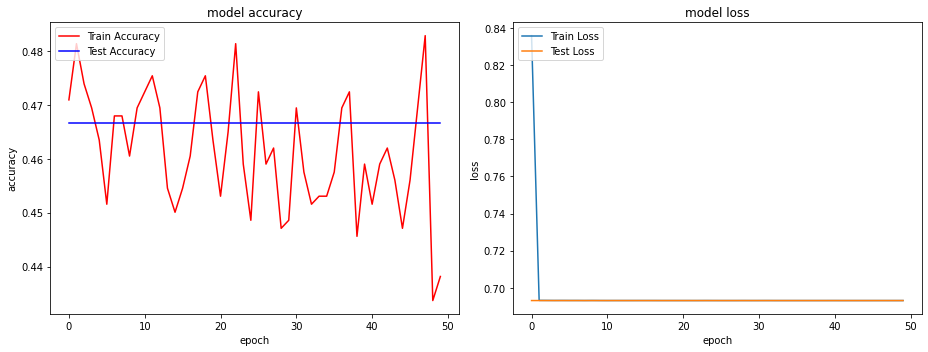

In [ ]:
#@title Accuracy and Loss Plots { vertical-output: true, display-mode: "form" }
plothistory(history_augm)

5/5 [==============================] - 1s 105ms/step
	Training Accuracy :  0.46944858420268254 			Testing Accuracy :  0.4666666666666667


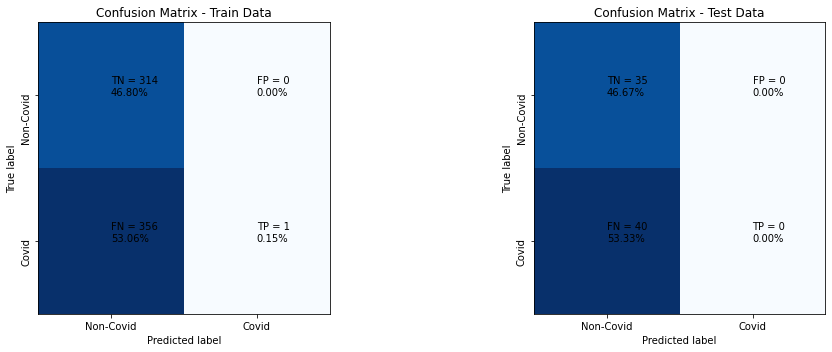

+------------------------+---------------------------------------+
|  Preformance_Metrics   | Proposed CNN with Image Augumentation |
+------------------------+---------------------------------------+
|       Precision        |          0.23333333333333334          |
|       Miss-Rate        |                  1.0                  |
|       Fall-out         |                  0.0                  |
| Sensitivity or recall  |                  0.5                  |
|       Accuracy         |           0.4666666666666667          |
|      Specificity       |                  1.0                  |
|       F1 Score         |           0.3181818181818182          |
| Similarity of Jaccard  |                  0.0                  |
|        S-dice          |                  0.0                  |
+------------------------+---------------------------------------+


In [ ]:
#@title Construct Confusion Matrix and Performance Metrics { display-mode: "form" }

def confusematrix_gen(model,train_generator,test_generator,batch_size,classNames):
    yhat = model.predict(train_generator, batch_size+1, verbose=1, workers=0)
    yhat = np.argmax(yhat, axis=1)
    cm_train=confusion_matrix(train_generator.classes,yhat)
   
    pred = model.predict(test_generator, batch_size+1, verbose=1, workers=0)
    pred = np.argmax(pred, axis=1)
    cm_test=confusion_matrix(test_generator.classes,pred)
    print('\tTraining Accuracy : ',accuracy_score(train_generator.classes,yhat),'\t\t\tTesting Accuracy : ',accuracy_score(test_generator.classes,pred))
    
    plotconfusematrix(cm_train,cm_test,classNames)
    performance_metrics(test_generator.classes,pred,cm_test,'Proposed CNN with Image Augumentation')

confusematrix_gen(augmodel,train_generator,test_generator,16,classNames)



---

#### Building and Training a Pre-Trained Model 

---



In [ ]:
#@title Build Pre-trained Model { vertical-output: true, display-mode: "form" }
def pretrainedmodel():
  ## build network
  baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
  # construct the head of the model that will be placed on top of the
  # the base model
  headModel = baseModel.output
  headModel = BatchNormalization()(headModel)
  headModel = Activation('relu')(headModel)
  headModel = Dropout(0.4)(headModel)
  headModel = Flatten(name="flatten")(headModel)
  headModel = Dense(128, activation="relu")(headModel)
  headModel = Dense(2, activation="softmax")(headModel)
  # place the head FC model on top of the base model (this will become
  # the actual model we will train)
  model = Model(inputs=baseModel.input, outputs=headModel)
  for layer in baseModel.layers:
    layer.trainable = False
  opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
  model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
  model.summary()
  return model
model = pretrainedmodel()

58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_______________________________________________________

In [ ]:
#@title Training The Pre-trained Model { vertical-output: true, display-mode: "form" }
# Define a Callback class that stops training once accuracy reaches 91.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.93):
      print("\nReached 91% accuracy so cancelling training!")
      self.model.stop_training = True
checkpoint = ModelCheckpoint(r'Covid_result_Pretrained.h5',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy',min_delta=0,patience=5,verbose=2,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.2,patience=5,verbose=2,min_delta=0.0001)

history = model.fit(
                    x = trainX, 
                    y = trainY,
                    batch_size=BS,
                    epochs = EPOCHS,
                    callbacks = [myCallback(),checkpoint],
                    steps_per_epoch=len(trainX) // BS,
                    validation_data=(testX, testY),
                    validation_steps=len(testX) // BS,
                    )

#print("[INFO] saving COVID-19 detector model...")
#model.save("covid19.model", save_format="h5")

Epoch 1/500
37/37 [==============================] - ETA: 0s - loss: 5.7410e-06 - accuracy: 1.0000
Epoch 00001: val_accuracy improved from -inf to 0.84722, saving model to Covid_result_Pretrained.h5
37/37 [==============================] - 3s 86ms/step - loss: 5.7410e-06 - accuracy: 1.0000 - val_loss: 0.8794 - val_accuracy: 0.8472
Epoch 2/500
37/37 [==============================] - ETA: 0s - loss: 5.7206e-06 - accuracy: 1.0000
Epoch 00002: val_accuracy improved from 0.84722 to 0.85417, saving model to Covid_result_Pretrained.h5
37/37 [==============================] - 3s 82ms/step - loss: 5.7206e-06 - accuracy: 1.0000 - val_loss: 0.8169 - val_accuracy: 0.8542
Epoch 3/500
37/37 [==============================] - ETA: 0s - loss: 1.0664e-05 - accuracy: 1.0000
Epoch 00003: val_accuracy improved from 0.85417 to 0.86111, saving model to Covid_result_Pretrained.h5
37/37 [==============================] - 3s 82ms/step - loss: 1.0664e-05 - accuracy: 1.0000 - val_loss: 0.7989 - val_accuracy: 0.

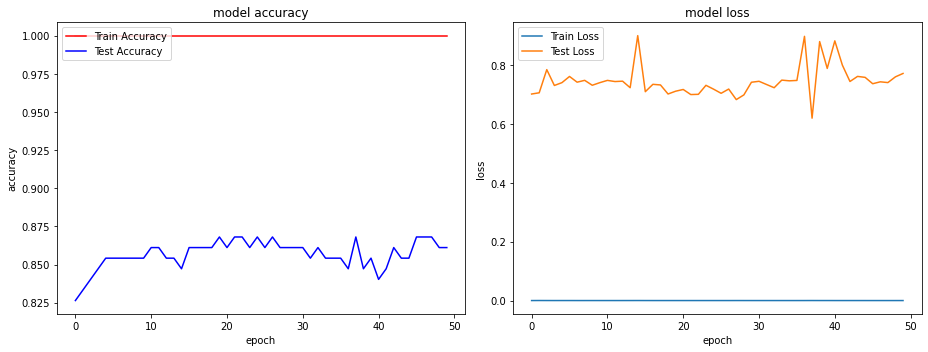

In [ ]:
#@title Accuracy and Loss Plots for Pre-Trained model { vertical-output: true, display-mode: "form" }
plothistory(history)

 	Training Accuracy :  1.0 			Testing Accuracy :  0.86


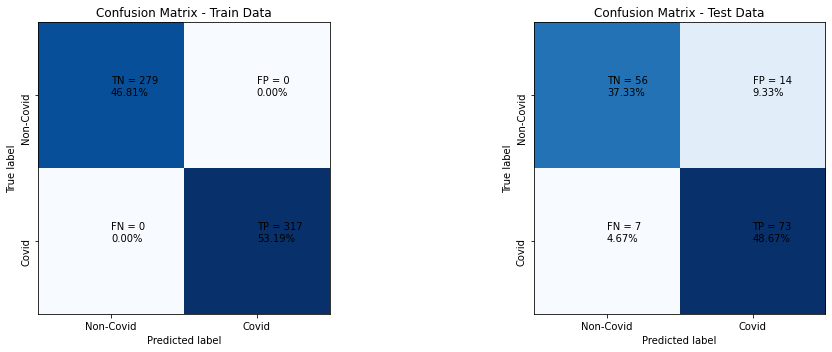

              precision    recall  f1-score   support

       COVID       0.89      0.80      0.84        70
    NonCOVID       0.84      0.91      0.87        80

    accuracy                           0.86       150
   macro avg       0.86      0.86      0.86       150
weighted avg       0.86      0.86      0.86       150



In [ ]:
#@title plotting confusion matrix and classification Report for PreTrained model { vertical-output: true, display-mode: "form" }
new_model = tf.keras.models.load_model('/content/Covid_result_Pretrained.h5')
y_test,yhat,cm = confusematrix(new_model,trainX,trainY,testX,testY,classNames)
print(classification_report(y_test, yhat,target_names=lb.classes_))

In [ ]:
#@title Performance Metrics for Pre-trained Model{ vertical-output: true, display-mode: "form" }
performance_metrics(y_test,yhat,cm,'Pre-trained Model')

TypeError: ignored

In [ ]:
#@title Comparision of Performance Metrics { vertical-output: true, display-mode: "form" }
from prettytable import PrettyTable

def performance_metrics(y_test_cnn,yhat_cnn,cm_cnn,y_test_dnn,yhat_dnn,cm_dnn):
    TP_cnn = cm_cnn[1][1]
    TN_cnn = cm_cnn[0][0]
    FP_cnn = cm_cnn[0][1]
    FN_cnn = cm_cnn[1][0]

    TP_dnn = cm_dnn[1][1]
    TN_dnn = cm_dnn[0][0]
    FP_dnn = cm_dnn[0][1]
    FN_dnn = cm_dnn[1][0]
    t = PrettyTable(['Preformance_Metrics','DNN','CNN'])
    t.add_row(['Precision ',precision_score(y_test_dnn, yhat_dnn, average="macro"),precision_score(y_test_cnn, yhat_cnn, average="macro")])
    t.add_row(['Miss-Rate ', FN_dnn / (FN_dnn + TP_dnn), FN_cnn / (FN_cnn + TP_cnn)])
    t.add_row(['Fall-out ', FP_dnn / (FN_dnn + TP_dnn), FP_cnn / (FN_cnn + TP_cnn)])
    t.add_row(['Sensitivity or recall ',recall_score(y_test_dnn, yhat_dnn , average="macro"),recall_score(y_test_cnn, yhat_cnn , average="macro")])
    t.add_row(['Accuracy ',accuracy_score(y_test_dnn,yhat_dnn),accuracy_score(y_test_cnn,yhat_cnn)])
    t.add_row(['Specificity ', TN_dnn/(TN_dnn + FP_dnn), TN_cnn/(TN_cnn + FP_cnn)])
    t.add_row(['F1 Score ',f1_score(y_test_dnn, yhat_dnn , average="macro"),f1_score(y_test_cnn, yhat_cnn , average="macro")])
    t.add_row(['Similarity of Jaccard',jaccard_similarity_score(y_test_dnn, yhat_dnn),jaccard_similarity_score(y_test_cnn, yhat_cnn)])
    t.add_row(['S-dice ',(2*TP_dnn)/(2*TP_dnn + FP_dnn + FN_dnn),(2*TP_cnn)/(2*TP_cnn + FP_cnn + FN_cnn)])  
    print(t)
performance_metrics(y_test,yhat,cm,y_test_dnn,pred,cm_dnn)

In [ ]:
import pickle as pk
pk.dump(pca, open("pca.pkl","wb"))
pca_reload = pk.load(open("pca.pkl",'rb'))
result_new = pca_reload .transform(x_std)
#x_new = pca.fit_transform(x_std)

In [ ]:
import pickle
map = {'X_train_dnn':X_train,
       'X_test_dnn' :X_test_dnn,
       'y_train_dnn':y_train,
       'y_test_dnn' :y_test_dnn,
       'X_train_cnn':trainX, 
       'X_test_cnn' :testX, 
       'y_train_cnn':trainY, 
       'y_test_cnn':testY
       }
#for k,v in map:
 # path = str('/content/drive/MyDrive/MiniProject/version1')+str(k+".pickle")
  #print(path+":"+type(v))
  #with open(path, 'wb') as f:
    #pickle.dump(v, f)
